## Rainfall and other ACIS data for counties, HUC8s, stations
using ACIS stations which use a variety of station data including Cocorahs, Hydrimet, etc.

station data can be filtered by HUC8, county, station number, or list of these

https://water.usgs.gov/wsc/watershed_finder.html for finding HUC8 basin codes

ACIS documentation, including parameter codes: http://www.rcc-acis.org/docs_webservices.html

In [8]:
#basic imports
from climata.usgs import DailyValueIO
from climata.acis import StationDataIO
import pandas as pd, numpy as np
import folium  #folium on Jupyter doesn't display well in Microsoft Edge. Chrome works.
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8] #gives compact size to plots
%matplotlib inline

#some functions
def flashiness(series):
    """Richards-Baker Flashiness Index for a Pandas series of daily mean flows = the path length divided by the sum."""
    Qsum = np.sum(series)  # sum of daily flows
    # the path length, or sum of differences between adjacent daily flows:
    Qpath = np.sum(pd.Series(np.abs(series.shift(1)-series))) 
    return round(Qpath/Qsum,2)
    


def colorgrad(minimum, maximum, value):
    """returns a hex color for circle markers based on a value"""
    minimum, maximum = float(minimum), float(maximum)
    ratio = (value-minimum) / (maximum-minimum)
    g = int(max(0, 128*(1 - ratio)))
    r = int(max(0, 128*(1 - ratio) + 127))
    b = 0
    hexcolor = '#%02x%02x%02x' % (r,g,b)
    return hexcolor

In [9]:
stations = StationDataIO(
#     basin="11080008",
    county= "06069", #San Benito
    start_date="2012-10-01", #calendar year or water year? select dates accordingly
    end_date="2018-09-30",
    parameter="pcpn" # precipitation in inches
    # 'cdd' is cooling degree days above 65F, 'avgt' is average temp in F. See docs 
)
list(stations)

[StationDataIOTuple(name='PINNACLES NM', sids={'COOP': '046926', 'GHCN': 'USC00046926', 'NWSLI': 'PNMC1'}, county='06069', state='CA', elev=1307.0, climdiv='CA04', uid=2519, longitude=-121.1822, latitude=36.4819, data=<climata.acis.DataIO object at 0x00000276247DEC50>),
 StationDataIOTuple(name='HOLLISTER 2', sids={'COOP': '044025', 'GHCN': 'USC00044025', 'NWSLI': 'HOLC1'}, county='06069', state='CA', elev=275.0, climdiv='CA04', uid=2590, longitude=-121.4213, latitude=36.8483, data=<climata.acis.DataIO object at 0x00000276225C1F28>),
 StationDataIOTuple(name='HERNANDEZ CALIFORNIA', sids={'GHCN': 'USR0000CHER'}, county='06069', state='CA', elev=3733.0, climdiv='CA04', uid=66008, longitude=-120.8558, latitude=36.3825, data=<climata.acis.DataIO object at 0x0000027621D36278>),
 StationDataIOTuple(name='HOLLISTER CALIFORNIA', sids={'GHCN': 'USR0000CHLR'}, county='06069', state='CA', elev=404.0, climdiv='CA04', uid=66012, longitude=-121.3622, latitude=36.8422, data=<climata.acis.DataIO objec

In [11]:
#dataframe of station info
stationinfo = pd.DataFrame([[y for y in x] for x in stations],
columns=['name','codes','county','st','elev','climdiv','uid','lon','lat','data'])
#now map them
m = folium.Map(location=[stationinfo['lat'].mean(), stationinfo['lon'].mean()], zoom_start=9, tiles="Stamen Terrain")
for i in range(0,len(stationinfo)):
    tooltip = stationinfo.iloc[i]['name']
    folium.Marker([stationinfo.iloc[i]['lat'], stationinfo.iloc[i]['lon']],tooltip=tooltip).add_to(m)
m

In [12]:
#dataframe for rainfall measurements

for i in range(0,len(stations)):
    if i==0:
        dates = [r[0] for r in stations[i].data]
        pcpn = [r[1] for r in stations[i].data]
        df = pd.DataFrame(data = pcpn, columns = [stations[i].name], index=dates)
    else:
        df[stations[i].name] = [r[1] for r in stations[i].data]
#make sure it has a datetime index
df.index = pd.to_datetime(df.index)
df.describe()

,PINNACLES NM,HOLLISTER 2,HERNANDEZ CALIFORNIA,HOLLISTER CALIFORNIA,PINNACLES CALIFORNIA,SANTA RITA CALIFORNIA
count,2191.0,2191.0,2191.0,2191.0,2191.0,2191.0
unique,26.0,21.0,28.0,24.0,29.0,24.0
top,0.0,0.0,0.0,0.0,0.0,0.0
freq,1213.0,1583.0,1327.0,1549.0,1252.0,1394.0


In [16]:
#rank these stations by proportion of 'M' or missing values
miss = []
for col in df:
    miss.append(p[col].value_counts().to_dict()['M'])
a = pd.DataFrame(df.describe().transpose())
a['missing'] = miss
a = a.sort_values('missing')
a

,count,unique,top,freq,missing
HOLLISTER CALIFORNIA,2191.0,24.0,0.0,1549.0,2
PINNACLES CALIFORNIA,2191.0,29.0,0.0,1252.0,2
HERNANDEZ CALIFORNIA,2191.0,28.0,0.0,1327.0,16
HOLLISTER 2,2191.0,21.0,0.0,1583.0,54
SANTA RITA CALIFORNIA,2191.0,24.0,0.0,1394.0,108
PINNACLES NM,2191.0,26.0,0.0,1213.0,277


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000276247DE978>,
      dtype=object)

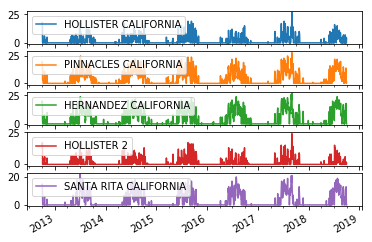

In [17]:
#select the best, with fewest missing values
top = 5
b = a[0:top] 
best = df[b.index]
best.replace(to_replace = ['M','T','S','A'], value=0, regex=True, inplace=True)
best.plot(subplots=True) 


In [6]:
years = best.groupby(pd.Grouper(freq='A-SEP')).agg({np.sum}) #'A-SEP' frequency is yearly, ending with end of September
# years.to_excel('sanBenito_rainfall.xls')
